# Project 2 : **INDEXING AND EVALUATION**

Èric Dalmases, Joel Duran & Marc Aguilar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import json
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pandas as pd
from datetime import datetime
from collections import defaultdict
import collections
from array import array
import math
import numpy as np
import time
from numpy import linalg as la

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1. Data Processing (Project 1)


In [ ]:
data_path = '/content/drive/Shareddrives/IRWA/Project - 1st Deliverable/IRWA_data_2023/'
tweets_path = 'Rus_Ukr_war_data.json'
maps_path = 'Rus_Ukr_war_data_ids.csv'
json_tweets = []
# We load the json tweets line by line
with open(f'{data_path}{tweets_path}', 'r') as file:
    for line in file:
        json_tweets.append(json.loads(line))

# We also load the document ids in a dataframe to perform the posterior mapping
documents = pd.read_csv(f'{data_path}{maps_path}', sep='\t', names=['doc_id', 'id'], index_col='id')

In [ ]:
class TextProcessor():
  @staticmethod
  def process(input: str) -> str:
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    output = input.lower() ## Transform in lowercase
    output = re.sub(r"(https?://\S+)|[^\w\s@🇺🇸🇺🇦🇷🇺🇨🇳🇪🇺🇹🇷]|\n|#", ' ', output) # Delete URLs, all symbols that are not mentions, hashtags or important flags (US, UA, RU)
    output = output.strip() # Delete spaces in front / at the end of the text ()
    output = re.split(r'\s+', output) # Split the text by spaces (same as output.split but considers a set of blank spaces as one)
    output = [i for i in output if i not in stop_words] # and .isalpha()
    output = [stemmer.stem(i) for i in output]
    return output

In [ ]:
# This class wil represent a single instance of a tweet
class Tweet:
  def __init__(self, id, user_id, username, doc_id, text, tokenized_text, date, hashtags, likes, retweets, url):
    self.id = id
    self.user_id = user_id
    self.username = username
    self.doc_id = doc_id
    self.text = text
    self.tokenized_text = tokenized_text
    self.date = date
    self.hashtags = hashtags
    self.likes = likes
    self.retweets = retweets
    self.url = url

  # This method is the one in charge of parsing the json data
  @classmethod
  def fromJson(self, json: str):
    doc_id = doc_id = documents.loc[int(json['id'])]['doc_id']
    return Tweet(
        id = json['id'],
        user_id = json['user']['id'],
        username = json['user']['screen_name'],
        doc_id = doc_id,
        text = json['full_text'],
        tokenized_text = TextProcessor.process((json['full_text'])),
        date = datetime.strptime(json['created_at'], "%a %b %d %H:%M:%S %z %Y"),
        hashtags = [h['text'] for h in json['entities']['hashtags']],
        likes = json['favorite_count'],
        retweets = json['retweet_count'],
        url = f"https://www.twitter.com/{json['user']['screen_name']}/status/{json['id']}"
    )

In [ ]:
# We load the all the tweets from the loaded jsons
tweets = []
for t in json_tweets:
  tweets.append(Tweet.fromJson(t))

# 2. Indexing

In [ ]:
def create_index_tfidf(tweets, num_documents):
    """
    Implement the inverted index and compute tf, df and idf

    Argument:
    tweets -- collection of Tweets
    num_documents -- total number of tweets

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    title_index = defaultdict(str)
    idf = defaultdict(float)

    for tweet in tweets:
        title = tweet.url
        page_id = tweet.doc_id
        terms = tweet.tokenized_text
        title_index[page_id] = title

        ## ===============================================================
        ## create the index for the **current page** and store it in current_page_index
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0,
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document.
            # posting ==> [current_doc, [list of positions]]
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf, title_index

In [ ]:
start_time = time.time()
num_documents = len(tweets)
index, tf, df, idf, title_index = create_index_tfidf(tweets, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 237.35 seconds


In [ ]:

def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)
    #print('len docs:', len(docs))

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]= query_terms_count[term]/ query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot

    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    scores = [x[0] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return doc_scores

In [ ]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = TextProcessor.process(query) # We use our custom processor for the text to match the processing performed to the tweets
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]

            # docs = docs Union term_docs
            docs = docs.union(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs = rank_documents(query, docs, index, idf, tf, title_index)
    return ranked_docs

## Our queries

In [ ]:
def getTweetFromDocId(docId):
  for tweet in tweets:
    if tweet.doc_id == docId:
      return tweet
  return None

In [ ]:
class Query:
  def __init__(self, query, query_id):
    self.query = query
    self.query_id = "Q"+str(query_id+1)
    self.tokenized_query = TextProcessor.process(query)
    self.relevant_tweets = set()
    self.non_relevant_tweets = set()
    self.tweets_relevancy = set()

  def addRelevantTweet(self, doc_id):
    if len(self.relevant_tweets) < 10:
      self.relevant_tweets.add(doc_id)

  def addNonRelevantTweet(self, doc_id):
    if len(self.non_relevant_tweets) < 10:
      self.non_relevant_tweets.add(doc_id)

In [ ]:
class TweetSimilarityPair:
  def __init__(self, tweet, similarity):
    self.tweet = tweet
    self.similarity = similarity


  @staticmethod
  def fromScoreList(scores, tweet):
    for pair in scores:
      if pair[1] == tweet.doc_id:
        return TweetSimilarityPair(tweet, pair[0])
    return TweetSimilarityPair(tweet, 0)

In [ ]:
queries_text = ["presidents visiting Kyiv", "conflict in Ukraine", "gas in Ukraine", "killing innocents", "donations for Ukraine"]
our_queries = []
for i, text in enumerate(queries_text):
  our_queries.append(Query(text, i))

In [ ]:
rel = {} # We store how many elements there are in the intesection of the tweet and the query
for q in our_queries:
  rel[q] = []
  for t in tweets:
    if len(set(q.tokenized_query).intersection(set(t.tokenized_text))) > 0:
      rel[q].append([t.doc_id, len(set(q.tokenized_query).intersection(set(t.tokenized_text)))])

In [ ]:
relevant = {}
for key in rel.keys():
  relevant[key] = []
# We filter them select the final ones, checking the uniqueness
for key in rel.keys():
  rel[key].sort(key=lambda x: x[1], reverse=True)
  i = 0
  while len(relevant[key])<10:
    element = rel[key][i]
    isInAnother = False
    for key2 in rel.keys():
      if element in relevant[key2] and key2 != key:
        isInAnother = True
    if not isInAnother:
      relevant[key].append(element)
    i += 1

In [ ]:
for q in our_queries:
  for pair in relevant[q]:
    doc_score = search_tf_idf(q.query, index)
    pair = TweetSimilarityPair.fromScoreList(doc_score, getTweetFromDocId(pair[0]))
    q.addRelevantTweet(pair)

In [ ]:
# We select the non relevant tweets
for q in our_queries:
  for t in tweets:
    isInAnother = False
    for q2 in our_queries:
      rel = list(map(lambda x: x.tweet, q2.relevant_tweets))
      non_rel = list(map(lambda x: x.tweet, q2.non_relevant_tweets))
      if q != q2 and t in rel and t in non_rel:
        isInAnother = True

    if not isInAnother and len(q.non_relevant_tweets) < 10:
      scores = search_tf_idf(q.query, index)
      q.addNonRelevantTweet(TweetSimilarityPair.fromScoreList(scores, t))

In [ ]:
for q in our_queries:
  for pair in q.relevant_tweets:
    print(f"Relevant tweet: {pair.tweet} | Score: {pair.similarity}")
  for pair in q.non_relevant_tweets:
    print(f"Non Relevant tweet: {pair.tweet} | Score: {pair.similarity}")

Relevant tweet: <__main__.Tweet object at 0x7ddea128a320> | Score: 2.7952187878180785
Relevant tweet: <__main__.Tweet object at 0x7ddea1611ed0> | Score: 3.3959729370930103
Relevant tweet: <__main__.Tweet object at 0x7ddea1612fe0> | Score: 1.447315887204604
Relevant tweet: <__main__.Tweet object at 0x7ddea1612b90> | Score: 1.1829289632478195
Relevant tweet: <__main__.Tweet object at 0x7ddea1612d40> | Score: 0.7104573359151104
Relevant tweet: <__main__.Tweet object at 0x7ddea13f8430> | Score: 4.018516096963406
Relevant tweet: <__main__.Tweet object at 0x7ddea12f20e0> | Score: 8.120137165477871
Relevant tweet: <__main__.Tweet object at 0x7ddea1610f70> | Score: 1.7855938608411828
Relevant tweet: <__main__.Tweet object at 0x7ddede0f9fc0> | Score: 3.3181550421092108
Relevant tweet: <__main__.Tweet object at 0x7ddea13f8370> | Score: 3.8908947491899752
Non Relevant tweet: <__main__.Tweet object at 0x7ddea1611990> | Score: 0
Non Relevant tweet: <__main__.Tweet object at 0x7ddea16132e0> | Score:

In [ ]:
for q in our_queries:
  print(f"Query : {q.query}")
  doc_scores = search_tf_idf(q.query, index)
  ranked_docs = [x[1] for x in doc_scores]
  top = 10

  print("Top {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
  for d_id in ranked_docs[:top]:
      print("page_id= {} - page_title: {}".format(d_id, title_index[d_id]), "\n")
  print("======================\n")

Query : presidents visiting Kyiv
Top 10 results out of 214 for the searched query:

page_id= doc_1243 - page_title: https://www.twitter.com/Ukrinform_News/status/1575768808337412098 

page_id= doc_2308 - page_title: https://www.twitter.com/infussambas/status/1575511622302695425 

page_id= doc_2394 - page_title: https://www.twitter.com/suspilne_news/status/1575487317438910465 

page_id= doc_1314 - page_title: https://www.twitter.com/KFDWB/status/1575757693931118592 

page_id= doc_1279 - page_title: https://www.twitter.com/KFDWB/status/1575761960158765056 

page_id= doc_3885 - page_title: https://www.twitter.com/IWPR/status/1575168706434301962 

page_id= doc_656 - page_title: https://www.twitter.com/ndtv/status/1575827101030064128 

page_id= doc_3904 - page_title: https://www.twitter.com/simpreslogistis/status/1575164742859378689 

page_id= doc_3903 - page_title: https://www.twitter.com/simpreslogistis/status/1575164800157351942 

page_id= doc_1443 - page_title: https://www.twitter.com/P

# 3. Evaluation

In [ ]:
class Evaluation:
  @staticmethod
  def precision(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k]) #y_true
    relevant = sum(doc_score==1)
    return float(relevant)/k

  @staticmethod
  def recall(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    total_relevant_docs = np.sum(doc_score == 1)
    doc_score = np.take(doc_score, order[:k]) #y_true
    relevant = sum(doc_score==1)
    return float(relevant)/total_relevant_docs

  @staticmethod
  def avgPrecision(doc_score, y_score, k=10):
    gtp = np.sum(doc_score == 1)
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i/(i+1)
    return prec_at_i/gtp

  @staticmethod
  def F1Score(doc_score, y_score, k=10):
    precision = Evaluation.precision(doc_score, y_score, k)
    recall = Evaluation.recall(doc_score, y_score, k)
    f1_score = 2*(precision*recall)/(precision+recall)
    return f1_score



  @staticmethod
  def map(search_res, k=10):
    avp = []
    for q in search_res['query_id'].unique():
        curr_data = search_res[search_res['query_id'] == q]
        avp.append(Evaluation.avgPrecision(np.array(curr_data['label']),
                                      np.array(curr_data['score']),
                                      k))
    return sum(avp)/len(avp), avp

  @staticmethod
  def mrr(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    if np.sum(doc_score) == 0:
        return 0
    return 1/(np.argmax(doc_score==1)+1)

  @staticmethod
  def dcg(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    gain = 2**doc_score-1
    discounts = np.log2(np.arange(len(doc_score))+2)
    return np.sum(gain / discounts)

  @staticmethod
  def ndcg(doc_score, y_score, k=10):
    dcg_max = Evaluation.dcg(doc_score, doc_score, k)
    if not dcg_max:
        return 0
    return np.round(Evaluation.dcg(doc_score, y_score, k)/dcg_max, 4)

  @staticmethod
  def execute_all(search_res, k=10):
    print("==> Precision @{}: {}\n".format(k, Evaluation.precision(search_res["label"], search_res['score'], k)))
    print("==> Recall @{}: {}\n".format(k, Evaluation.recall(search_res["label"], search_res['score'], k)))
    print("==> Average Precision@{}: {}\n".format(k, Evaluation.avgPrecision(np.array(search_res["label"]), np.array(search_res["score"]), k)))
    print("==> F1 Score @{}: {}\n".format(k, Evaluation.F1Score(search_res["label"], search_res['score'], k)))
    print("==> Mean Reciprocal Rank @{}: {}\n".format(k, np.round(Evaluation.mrr(search_res['label'], search_res['score'], 10), 4)))
    print("==> Normalized Discounted Cumulative Gain @{}: {}".format(k, np.round(Evaluation.ndcg(search_res['label'], search_res['score'], k), 4)))

  @staticmethod
  def evaluate_queries(queries):
    map = []
    for q1 in queries:
      doc_score = [rel.similarity for rel in q1.relevant_tweets] + [nonrel.similarity for nonrel in q1.non_relevant_tweets]
      y_score = [1] * len(q1.relevant_tweets)  + [0] * len(q1.non_relevant_tweets)
      for q2 in queries:
        if q1 != q2:
          doc_score += [nonrel.similarity for nonrel in q2.non_relevant_tweets]
          y_score += [0] * len(q2.non_relevant_tweets)
      query_id = [q1.query_id]*len(y_score)
      search_res = pd.DataFrame(data = {'query_id': query_id, 'score': doc_score, 'label': y_score}, columns=['query_id', 'score', 'label'])
      print(f"\n\nQuery: {q1.query}\n")
      Evaluation.execute_all(search_res, k=10)
      map.append(Evaluation.avgPrecision(np.array(search_res["label"]), np.array(search_res["score"]), k=10))
    print(f"\n\n MEAN AVERAGE PRECISION: {sum(map)/len(map)}")


In [ ]:
evaluation_queries = []
evaluation_df = pd.read_csv("/content/drive/Shareddrives/IRWA/Project - 2n Deliverable/Evaluation_gt.csv").set_index('doc')
for idx, text in enumerate(["tank in Kharkiv", "Nord Stream pipeline", "annexation of territories by Russia"]):
  q = Query(text, idx)
  doc_scores = search_tf_idf(q.query, index)
  for docid, row in evaluation_df.iterrows():
    tweet = getTweetFromDocId(docid)
    assert tweet != None, f"Tweet with doc id {docid} not found"
    if row["query_id"] == f"Q{idx+1}" and row["label"] == 1 :
      q.addRelevantTweet(TweetSimilarityPair.fromScoreList(doc_scores, tweet))
    elif row["query_id"] == f"Q{idx+1}":
      q.addNonRelevantTweet(TweetSimilarityPair.fromScoreList(doc_scores, tweet))
  evaluation_queries.append(q)

In [ ]:
Evaluation.evaluate_queries(evaluation_queries)



Query: tank in Kharkiv

==> Precision @10: 0.7

==> Recall @10: 0.7

==> Average Precision@10: 0.5833333333333333

==> F1 Score @10: 0.7

==> Mean Reciprocal Rank @10: 1.0

==> Normalized Discounted Cumulative Gain @10: 0.7503


Query: Nord Stream pipeline

==> Precision @10: 1.0

==> Recall @10: 1.0

==> Average Precision@10: 1.0

==> F1 Score @10: 1.0

==> Mean Reciprocal Rank @10: 1.0

==> Normalized Discounted Cumulative Gain @10: 1.0


Query: annexation of territories by Russia

==> Precision @10: 0.8

==> Recall @10: 0.8

==> Average Precision@10: 0.6484920634920635

==> F1 Score @10: 0.8000000000000002

==> Mean Reciprocal Rank @10: 1.0

==> Normalized Discounted Cumulative Gain @10: 0.7917


 MEAN AVERAGE PRECISION: 0.7439417989417989


In [ ]:
Evaluation.evaluate_queries(our_queries)



Query: presidents visiting Kyiv

==> Precision @10: 1.0

==> Recall @10: 1.0

==> Average Precision@10: 1.0

==> F1 Score @10: 1.0

==> Mean Reciprocal Rank @10: 1.0

==> Normalized Discounted Cumulative Gain @10: 1.0


Query: conflict in Ukraine

==> Precision @10: 1.0

==> Recall @10: 1.0

==> Average Precision@10: 1.0

==> F1 Score @10: 1.0

==> Mean Reciprocal Rank @10: 1.0

==> Normalized Discounted Cumulative Gain @10: 1.0


Query: gas in Ukraine

==> Precision @10: 1.0

==> Recall @10: 1.0

==> Average Precision@10: 1.0

==> F1 Score @10: 1.0

==> Mean Reciprocal Rank @10: 1.0

==> Normalized Discounted Cumulative Gain @10: 1.0


Query: killing innocents

==> Precision @10: 1.0

==> Recall @10: 1.0

==> Average Precision@10: 1.0

==> F1 Score @10: 1.0

==> Mean Reciprocal Rank @10: 1.0

==> Normalized Discounted Cumulative Gain @10: 1.0


Query: donations for Ukraine

==> Precision @10: 0.6

==> Recall @10: 0.6

==> Average Precision@10: 0.6

==> F1 Score @10: 0.6

==> Mean Re

# 4. TSNE and Word2Vec visualization

In [ ]:
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tweets = []
for q in our_queries+evaluation_queries:
  for t in q.relevant_tweets:
    tweets.append(t.tweet.tokenized_text)
  for t in q.non_relevant_tweets:
    tweets.append(t.tweet.tokenized_text)

model1 = Word2Vec(tweets, min_count = 1, vector_size = 300, window = 5)

In [ ]:
def average_vector(tokens, model):
    # Filter out words that are not in the vocabulary
    tokens = [word for word in tokens if word in model.wv.key_to_index]

    if len(tokens) == 0:
        return np.zeros(model.wv.vector_size)

    # Calculate the average vector for the given tokens
    vector_sum = np.zeros(model.wv.vector_size)
    for word in tokens:
        vector_sum += model.wv[word]

    return vector_sum / len(tokens)


def plot_queries_tsne(plotted_queries, plotname):
  queries_embedded = []
  relevant_tweets = {}
  nonrelevant_tweets = {}
  embedding_clusters = []
  labels = []
  scores = []

  for q in plotted_queries:
    vec = average_vector(q.tokenized_query, model1)
    embedding_clusters.append(vec)
    labels.append('Query')
    scores.append(1)

  # Calculate average vectors for each tweet and for each query
  for q in plotted_queries:
    relevant_tweets[q] = []
    nonrelevant_tweets[q] = []
    for t in q.relevant_tweets:
      vec = average_vector(t.tweet.tokenized_text, model1)
      embedding_clusters.append(vec)
      labels.append('Relevant')
      scores.append(t.similarity)
      relevant_tweets[q].append(vec)

    for t in q.non_relevant_tweets:
      vec = average_vector(t.tweet.tokenized_text, model1)
      embedding_clusters.append(vec)
      labels.append('Non-relevant')
      scores.append(t.similarity)
      relevant_tweets[q].append(vec)

  palette = {"Relevant":"tab:green",
           "Non-relevant":"tab:red",
           "Query":"tab:blue"}

  embedding_clusters = np.array(embedding_clusters)
  tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=5000, random_state=32)
  embeddings = tsne.fit_transform(embedding_clusters)

  first_dim = embeddings[:, 0]
  second_dim = embeddings[:, 1]
  df_scatter = pd.DataFrame(data = {'first_dim': first_dim, 'second_dim':second_dim, 'label': labels, 'scores': scores}, columns=['first_dim', 'second_dim', 'label', 'scores'])
  sns.scatterplot(data=df_scatter, x='first_dim', y='second_dim', hue='label', size=scores, palette=palette)
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.savefig(f"/content/drive/Shareddrives/IRWA/Project - 2n Deliverable/plots/{plotname}.jpg", bbox_inches='tight')



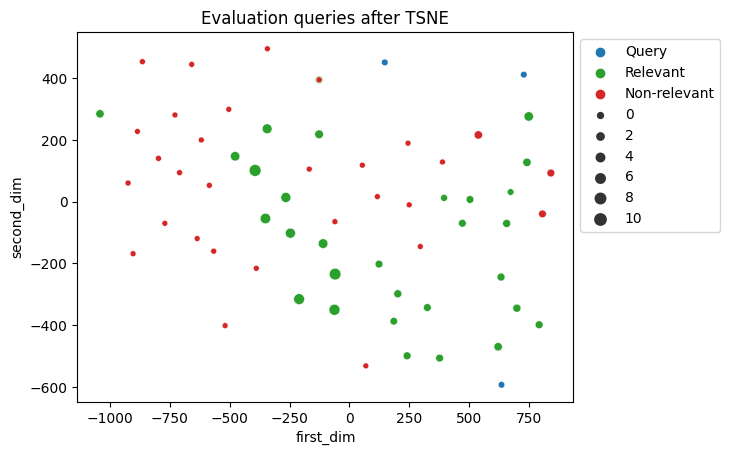

In [ ]:
plt.title("Evaluation queries after TSNE")
plot_queries_tsne(evaluation_queries, "evaluation_queries")

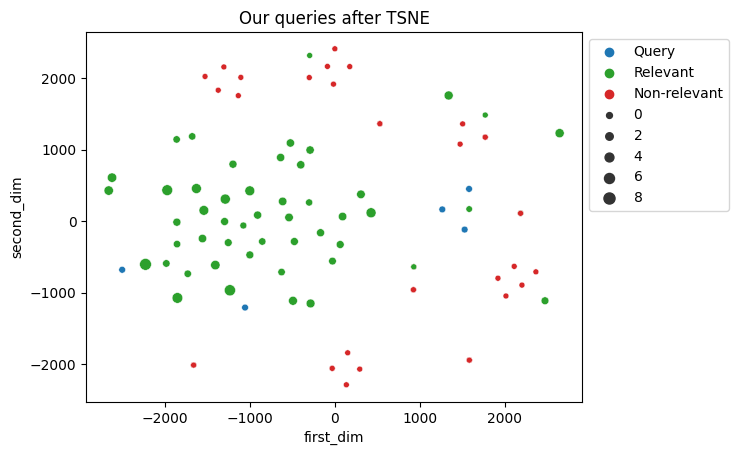

In [ ]:
plt.title("Our queries after TSNE")
plot_queries_tsne(our_queries, 'our_queries')

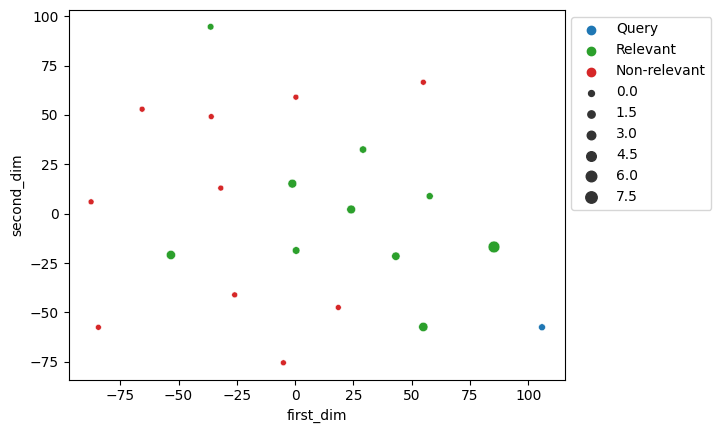

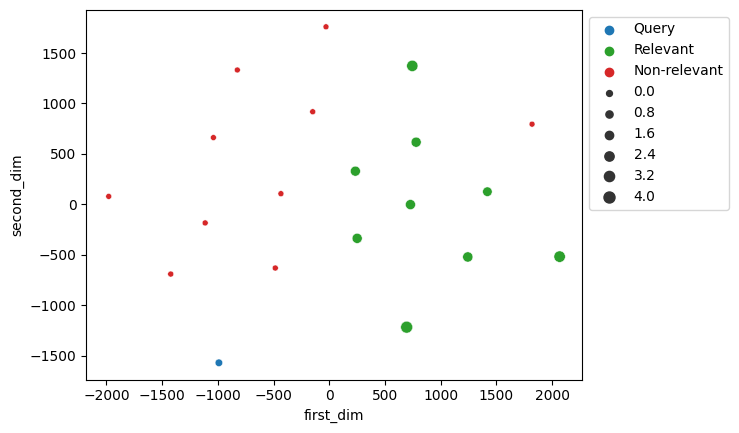

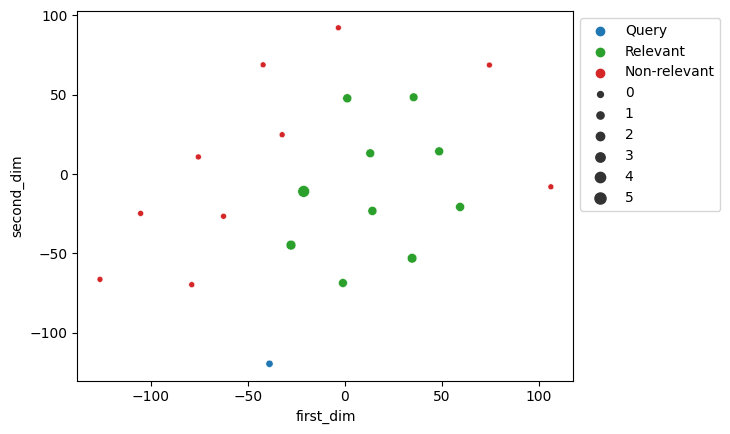

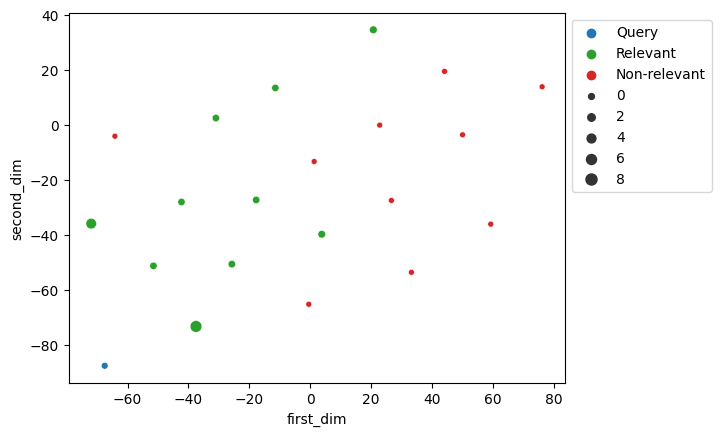

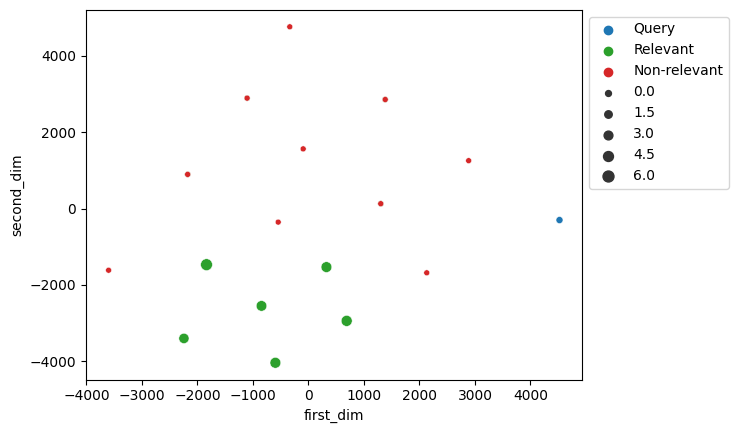

In [ ]:
for i, query in enumerate(our_queries):
  plt.figure(i)
  plot_queries_tsne([query], f"our_queries_{i}")
  plt.show()